# Meta-Training SNNs using MAML

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from collections import OrderedDict

from yingyang.dataset import YinYangDataset

import random
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import argparse
from torchviz import make_dot
from tqdm.notebook import tqdm, trange

In [ ]:
from tqdm.notebook import trange

In [2]:
%load_ext autoreload
%autoreload 2

## Data and Config

In [3]:
from eventprop.config import get_flat_dict_from_nested

In [65]:
data_config = {
    "seed": 42,
    "dataset": "ying_yang",
    "deterministic": True,
    "meta_batch_size": 1,
    "encoding": "latency",
    "T": 50,
    "dt": 1e-3,
    "t_min": 0,
    "t_max": 2,
    "data_folder": "../../../data/",
    "n_samples_per_task": 100,  # adaptation steps
    "n_tasks_per_split_train": 20,  # number of rotations
    "n_tasks_per_split_test": 20,  # number of rotations
    "n_tasks_per_split_val": 20,  # number of rotations
    "dataset_size": 1000,  # testing size
}
data_args = argparse.Namespace(**data_config)

In [66]:
torch.manual_seed(data_config["seed"])
np.random.seed(data_config["seed"])
random.seed(data_config["seed"])

data_config["dataset"] = data_config["dataset"]
if data_config["deterministic"]:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [67]:
torch.cuda.is_available()

False

## Rotation Ying Yang data for Meta Learning

In [68]:
from yingyang.meta_dataset import YingYangMetaDataset
from torchmeta.utils.data import BatchMetaDataLoader
from eventprop.training import encode_data
from torchmeta.transforms import ClassSplitter

In [69]:
encode_tranform = lambda s: (encode_data(s[0], data_args), s[1])

dataset_split = lambda d: ClassSplitter(
    d,
    num_train_per_class=data_config["dataset_size"],
    num_test_per_class=data_config["dataset_size"],
    shuffle=False,
)

meta_train_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_train=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)
meta_val_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_val=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)
meta_test_dataset = YingYangMetaDataset(
    num_classes_per_task=1,
    meta_test=True,
    transform=encode_tranform,
    data_config=data_config,
    dataset_transform=dataset_split,
)

meta_train_dataloader = BatchMetaDataLoader(
    meta_train_dataset,
    data_config["meta_batch_size"],
    shuffle=True,
    num_workers=0,
)

meta_val_dataloader = BatchMetaDataLoader(
    meta_val_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

meta_test_dataloader = BatchMetaDataLoader(
    meta_test_dataset,
    data_config["meta_batch_size"],
    shuffle=False,
    num_workers=0,
)

In [70]:
len(meta_train_dataset)

40

In [71]:
next(iter(meta_train_dataloader))["train"][0].shape

torch.Size([1, 1000, 50, 1, 5])

In [10]:
training_batch = next(iter(meta_train_dataloader))
testing_batch = next(iter(meta_test_dataloader))

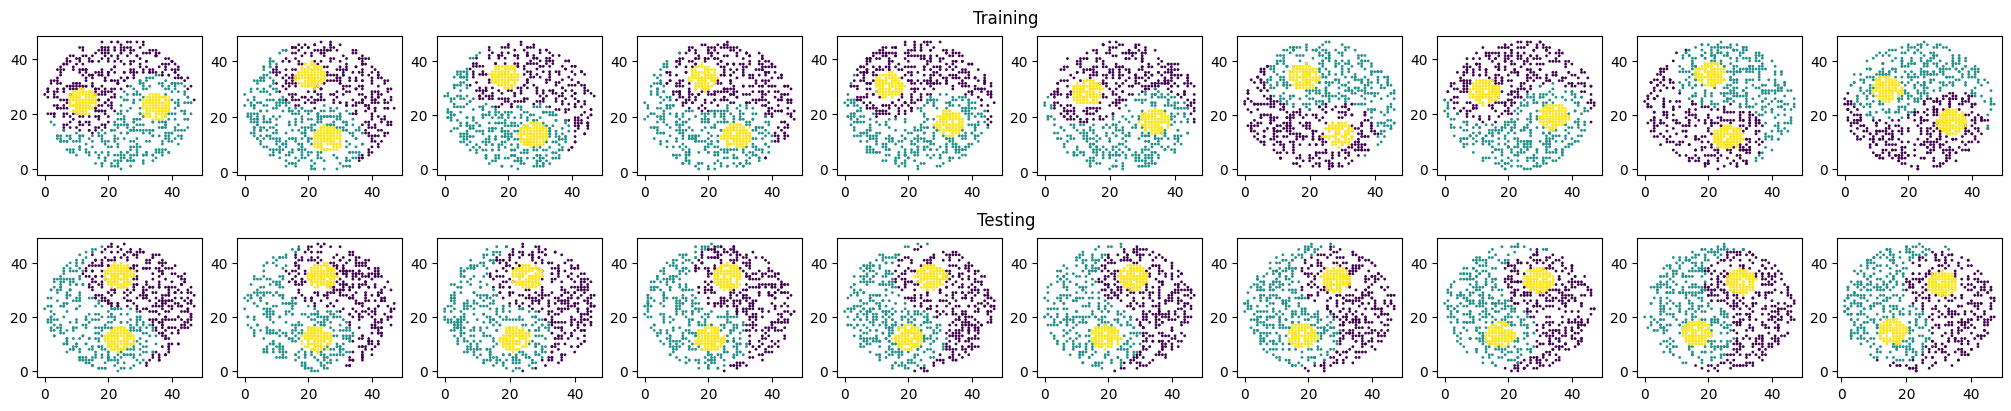

In [11]:
fig = plt.figure(figsize=(2 * data_config["meta_batch_size"], 4), constrained_layout=True)
subfigs = fig.subfigures(2, 1)

for batch, subfig in zip([training_batch, testing_batch], subfigs):
    axs = subfig.subplots(1, data_config["meta_batch_size"])
    for i, (x, y) in enumerate(zip(*batch["train"])):
        try:
            ax = axs[i]
        except TypeError:
            ax = axs
        ax.scatter(
            x.argmax(1).squeeze()[:, 0], x.argmax(1).squeeze()[:, 1], c=y, cmap="viridis", s=1
        )
    subfig.suptitle("Training" if batch is training_batch else "Testing")

## Models

In [12]:
from eventprop.models import SNN, SpikeCELoss, FirstSpikeTime

In [13]:
model_config = {
    "model_type": "eventprop",
    "snn": {
        "T": data_config["T"],
        "dt": data_config["dt"],
        "tau_m": 20e-3,
        "tau_s": 5e-3,
    },
    "weights": {
        "init_mode": "kaiming_both",
        "scale_0_mu": 5,
        "scale_0_sigma": 3.5,
        "scale_1_mu": 5,
        "scale_1_sigma": 0.5,
        "n_hid": 120,
        "resolve_silent": False,
        "dropout": 0.0,
    },
    # "device": (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")),
    "device": torch.device("cpu"),
}

n_ins = {"mnist": 784, "ying_yang": 5 if data_config["encoding"] == "latency" else 4}
n_outs = {"mnist": 10, "ying_yang": 3}

In [30]:
loss_config = {
    "loss": "ce_temporal",
    "alpha": 3e-3,
    "xi": 0.5,
    "beta": 6.4,
}

optim_config = {
    'meta-lr' : 1e-2,	
    'inner-lr' : 1e-2,
    "optimizer": "adam",
    "gamma": 0.95,
}

meta_config = {
    'n_epochs': 20,
    "num_shots": 10,
    "n_samples_test": 1000,
    "first_order": True,
    "learn_step_size": False,
}

default_config = {
    "data": data_config,
    "model": model_config,
    "optim": optim_config,
    "meta": meta_config,
    'loss' : loss_config
}
config = get_flat_dict_from_nested(default_config)
args = argparse.Namespace(**config)

In [36]:
dims = [n_ins[config["dataset"]]]
if config["n_hid"] is not None and isinstance(config["n_hid"], list):
    dims.extend(config["n_hid"])
elif isinstance(config["n_hid"], int):
    dims.append(config["n_hid"])
dims.append(n_outs[config["dataset"]])

model = SNN(dims, **config).to(config["device"])
init_params = OrderedDict(model.meta_named_parameters()).copy()

SNN SCALE :  [[5, 3.5], [5, 0.5]]


## REPTILE

In [37]:
from eventprop.training import REPTILE

In [38]:
reptile_trainer = REPTILE(model, default_config)

In [39]:
train_accs = {
    "pre": [],
    "post": [],
}

test_accs = {
    "pre": [],
    "post": [],
}

all_accs = {
    "train" : train_accs,
    "test": test_accs,
}

In [46]:
for ep in trange(10, position=0, desc="Epochs"):

    for trial, accs in all_accs.items():
        for acc in accs.values():
            acc.append([])

    for training_batch in meta_train_dataloader:
        outer_loss, results = reptile_trainer.get_outer_loss(
            training_batch, use_tqdm=True, train=True, position=1
        )
        train_accs["pre"][-1].append([results["meta_accs"]["pre"]])
        train_accs["post"][-1].append([results["meta_accs"]["post"]])

    for testing_batch in meta_test_dataloader:
        outer_loss, results = reptile_trainer.get_outer_loss(
            testing_batch, use_tqdm=False, train=False
        )
        test_accs["pre"][-1].append([results["meta_accs"]["pre"]])
        test_accs["post"][-1].append([results["meta_accs"]["post"]])

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

Task:   0%|          | 0/10 [00:00<?, ?it/s]

In [60]:
train_accs = {
    k : np.array([np.mean(a) for a in accs]) for k, accs in train_accs.items()
}

/home/gbena/anaconda3/envs/cc_spinn/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/gbena/anaconda3/envs/cc_spinn/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [62]:
train_accs['post']

array([       nan, 0.41049996,        nan, 0.38296667, 0.3971    ,
       0.39932501, 0.40482497, 0.40469998, 0.40599999, 0.41494998,
       0.42189997, 0.42052498, 0.42642504, 0.40154997, 0.41685   ])

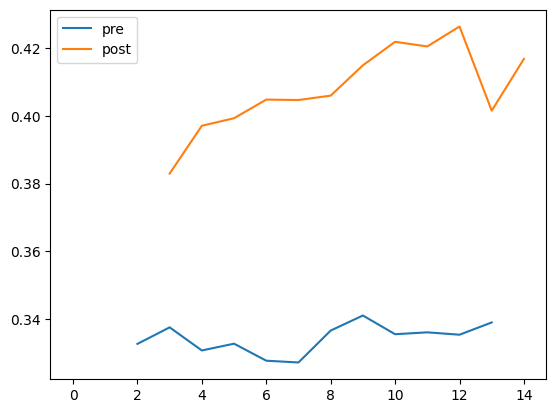

In [63]:
plt.plot(train_accs["pre"], label="pre")
plt.plot(train_accs["post"], label="post")
plt.legend()

In [ ]:
(
    training_batch["train"][1].float().mean(0)[None, :] == training_batch["train"][1].float()
).float().mean()

tensor(0.0424)

In [ ]:
import torchviz

In [ ]:
torchviz.make_dot(outer_loss, dict(model.named_parameters())).render("maml_loss")

'maml_loss.pdf'

## DEBUGGING / PROPTOTYPE

### Finding the joint-training baseline (training on all rotations at once)

In [ ]:
model = SNN(dims, **config).to(config["device"])
inner_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
maml_trainer = MAML(model, default_config)
maml_trainer.inner_optimizer = inner_optimizer

SNN SCALE :  [[5, 3.5], [5, 0.5]]


In [ ]:
batch_size = 512
inputs = (
    training_batch["train"][0].permute(2, 3, 4, 0, 1).flatten(start_dim=-2).permute(-1, 0, 1, 2)
)
random_idxs = torch.randperm(inputs.shape[0])
targets = training_batch["train"][1].flatten()
inputs, targets = inputs[random_idxs], targets[random_idxs]


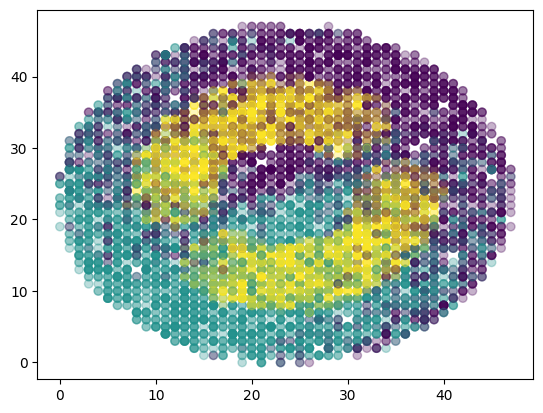

In [ ]:
plt.scatter(inputs.argmax(1)[:, 0, 0], inputs.argmax(1)[:, 0, 1], c=targets[:], alpha=.3)

In [ ]:
inputs, targets = inputs.split(batch_size), targets.split(batch_size)
for input, target, _ in zip(inputs, targets, trange(len(inputs))):
    maml_trainer.adapt((input, target))

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
test_accs = []
inputs = (
    training_batch["test"][0].permute(2, 3, 4, 0, 1).flatten(start_dim=-2).permute(-1, 0, 1, 2)
)
targets = training_batch["test"][1].flatten()
inputs, targets = inputs.split(batch_size), targets.split(batch_size)
for input, target, _ in zip(inputs, targets, trange(len(inputs))):
    acc, *_ = maml_trainer.inner_test((input, target))
    test_accs.append(acc)
    

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
np.mean(test_accs)

0.44818473

### Making sure we can overfit on one subtask

In [ ]:
inputs, targets = training_batch["test"]
inputs = inputs[0].to(config["device"])
targets = targets[0].to(config["device"])

acc, loss, recs = maml_trainer.inner_test((inputs, targets))
print(f"Pre Adaptation Accuracy: {acc}")

Pre Adaptation Accuracy: 0.5120000243186951


In [ ]:
inputs, targets = training_batch["train"]
inputs = inputs[0]
targets = targets[0].to(config["device"])
new_params = maml_trainer.adapt((inputs, targets), use_tqdm=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
inputs, targets = training_batch["test"]
inputs = inputs[0].to(config["device"])
targets = targets[0].to(config["device"])

acc, loss, recs = maml_trainer.inner_test((inputs, targets), new_params)
print(f"Post Adaptation Accuracy: {acc}")

Post Adaptation Accuracy: 0.5120000243186951


## Outer Loss